<div class="usecase-title">AI Pedestrian Flow Prediction</div>

<div class="usecase-authors"><b>Authored by: Adithya Sentil</b> </div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

<header>
<h2>Scenario</h2>
<div> The City of Melbourne experiences significant variations in pedestrian movement due to changing weather conditions, scheduled public events, and daily activity patterns. During large-scale events (e.g. F1 or AFL games), certain areas become heavily congested, while others remain underutilised. This makes it difficult for city planners and safety personnel to anticipate foot traffic and allocate resources efficiently.

To combat this I propose a predictive AI model that forecasts pedestrian flow across various sensors in the city using historical pedestrian count data, scheduled event data, event locations, and weather conditions. The outcome will help optimise public safety planning, infrastructure usage, and event coordination.  </div>

### User Story
**As** a city data scientist at the City of Melbourne,  
**I want** to use an AI model that can accurately predict pedestrian flow patterns based on historical pedestrian sensor data, weather conditions, and scheduled event data,  
**so that** I can provide insights to city planners and emergency services to proactively manage pedestrian movement and reduce overcrowding during high-traffic events.

## Introduction

Understanding pedestrian movement patterns is essential for enhancing city planning, improving public safety, and ensuring smooth mobility during both regular days and large-scale events. The City of Melbourne collects a vast amount of data from pedestrian sensors located across the city, which, when combined with contextual data such as weather conditions and event schedules, can provide valuable insights into human mobility.

This project focuses on developing an AI-based model that utilises the datasets to accurately predict pedestrian flow. By predicting movement trends, the city can proactively manage crowds, allocate resources efficiently, and optimise infrastructure usage. This approach not only supports safer and more efficient urban environments but also contributes to a smarter, data-driven city management strategy.


***Dataset Links*** 
- Pedestrian counting link: https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/api/
- Venue location data link: https://data.melbourne.vic.gov.au/explore/dataset/venues-for-event-bookings/api/ 
- Weather station data link: https://data.melbourne.vic.gov.au/explore/dataset/meshed-sensor-type-1/information/ 




### Importing Required Libraries 

In [422]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os
import requests 
from functools import reduce

## Importing Datasets


To build the AI-based pedestrian flow prediction model, we begin by importing the relevant datasets from the City of Melbourne Open Data API. The following datasets are used in this project:

- **Pedestrian Counting System**: Hourly pedestrian counts from sensors installed across the city.
- **Event Locations**: Data on the locations and timings of public events in Melbourne.
- **Weather Data**: Historical weather conditions including temperature, rainfall, and wind.

These datasets are accessed using API requests and loaded into pandas DataFrames for preprocessing and analysis.


In [424]:
def fetch_data(base_url, dataset, api_key, num_records=99, offset=0):
    all_records = []
    max_offset = 9900  # Maximum number of requests

    while True:
        # Maximum limit check
        if offset > max_offset:
            break

        # Create API request URL
        filters = f'{dataset}/records?limit={num_records}&offset={offset}'
        url = f'{base_url}{filters}&api_key={api_key}'

        # Start request
        try:
            result = requests.get(url, timeout=10)
            result.raise_for_status()
            records = result.json().get('results')
        except requests.exceptions.RequestException as e:
            raise Exception(f"API request failed: {e}")
        if records is None:
            break
        all_records.extend(records)
        if len(records) < num_records:
            break

        # Next cycle offset
        offset += num_records

    # DataFrame all data
    df = pd.DataFrame(all_records)
    return df

#os.environ.get('MELBOURNE_API_KEY')

# Retrieve API key from environment variable

BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

### Importing Pedestrian Count Data 

In [426]:
# Data set name
dataset_pedestrian_counting = 'pedestrian-counting-system-monthly-counts-per-hour'
# Fetch dataset 
pedestrian_counting = fetch_data(BASE_URL, dataset_pedestrian_counting, API_KEY)
# Create a new row named latitude
pedestrian_counting['latitude'] = pedestrian_counting['location'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
# Create a new row named longitude
pedestrian_counting['longitude'] = pedestrian_counting['location'].apply(lambda x: x['lon'] if isinstance(x, dict) else None)

pedestrian_counting.head(20)


id  location_id sensing_date  hourday  direction_1  \
0    452020240229           45   2024-02-29       20          376   
1   1431620250325          143   2025-03-25       16          221   
2   1351320240516          135   2024-05-16       13          424   
3   1321320240716          132   2024-07-16       13          204   
4   1071320250608          107   2025-06-08       13           75   
5   1071020231103          107   2023-11-03       10           99   
6    671720240915           67   2024-09-15       17          255   
7    671320250815           67   2025-08-15       13          440   
8     17120250521           17   2025-05-21        1            4   
9     24620250519           24   2025-05-19        6          331   
10    67020230921           67   2023-09-21        0           15   
11    72820240718           72   2024-07-18        8          725   
12    76820250826           76   2025-08-26        8           83   
13    27820250904           27   2025-09-04        8           76   
14    91420241021            9   2024-10-21       14          411   
15   532120241224           53   2024-12-24       21          319   
16   462120250322           46   2025-03-22       21            4   
17    30220250613           30   2025-06-13        2           28   
18   130720240815          130   2024-08-15        7            3   
19    49120241227           49   2024-12-27        1           34   

    direction_2  pedestriancount sensor_name  \
0           913             1289    Swa148_T   
1           221              442   Spencer_T   
2           469              893   Spen161_T   
3           182              386   King335_T   
4           127              202   280Will_T   
5           125              224   280Will_T   
6           421              676    FLDegS_T   
7           737             1177    FLDegS_T   
8             5                9     Col15_T   
9           152              483    Col620_T   
10           19               34    FLDegS_T   
11          108              833      ACMI_T   
12           52              135    KenMac_T   
13          119              195       Vic_T   
14          262              673    Col700_T   
15          396              715    Col254_T   
16            2                6    Pel147_T   
17           28               56    Lon189_T   
18            4                7     Bou892T   
19           27               61    Eli501_T   

                                      location   latitude   longitude  
0   {'lon': 144.96609379, 'lat': -37.81414075} -37.814141  144.966094  
1     {'lon': 144.95557015, 'lat': -37.821728} -37.821728  144.955570  
2    {'lon': 144.95319102, 'lat': -37.8172861} -37.817286  144.953191  
3   {'lon': 144.95386444, 'lat': -37.81267639} -37.812676  144.953864  
4   {'lon': 144.95690188, 'lat': -37.81246271} -37.812463  144.956902  
5   {'lon': 144.95690188, 'lat': -37.81246271} -37.812463  144.956902  
6   {'lon': 144.96562569, 'lat': -37.81688755} -37.816888  144.965626  
7   {'lon': 144.96562569, 'lat': -37.81688755} -37.816888  144.965626  
8   {'lon': 144.97323591, 'lat': -37.81362543} -37.813625  144.973236  
9   {'lon': 144.95449198, 'lat': -37.81887963} -37.818880  144.954492  
10  {'lon': 144.96562569, 'lat': -37.81688755} -37.816888  144.965626  
11  {'lon': 144.96872809, 'lat': -37.81726338} -37.817263  144.968728  
12  {'lon': 144.93036194, 'lat': -37.79453803} -37.794538  144.930362  
13  {'lon': 144.95644692, 'lat': -37.80606888} -37.806069  144.956447  
14  {'lon': 144.95102555, 'lat': -37.81982992} -37.819830  144.951026  
15    {'lon': 144.965499, 'lat': -37.81564191} -37.815642  144.965499  
16   {'lon': 144.9615673, 'lat': -37.80240719} -37.802407  144.961567  
17   {'lon': 144.96656806, 'lat': -37.8112185} -37.811219  144.966568  
18   {'lon': 144.94126826, 'lat': -37.8204637} -37.820464  144.941268  
19  {'lon': 144.95956055, 'lat': -37.80730068} -37.807301  144.959561

### Importing Weather Data 

In [428]:
# Data set name
weather_stations = 'meshed-sensor-type-1'
# Fetch dataset 
weather_stations_df = fetch_data(BASE_URL, weather_stations, API_KEY)


weather_stations_df.head(20)

device_id                       time        rtc  battery  solarpanel  \
0   atmos41-32fc  2025-08-16T20:40:34+00:00  121366929    4.140       1.458   
1   atmos41-32fc  2025-08-16T21:10:53+00:00  121368748    4.137      19.340   
2   atmos41-32fc  2025-08-16T20:10:00+00:00  121365095    4.140       0.225   
3   atmos41-32fc  2025-08-17T00:11:54+00:00  121379609    4.208      22.161   
4   atmos41-32fc  2025-08-17T02:26:30+00:00  121387685    4.209      22.064   
5   atmos41-32fc  2025-08-17T03:10:37+00:00  121390332    4.209      22.564   
6   atmos41-32fc  2025-08-17T03:25:44+00:00  121391239    4.208      22.338   
7   atmos41-32fc  2024-12-28T09:31:31+00:00  101368462    4.181      18.164   
8   atmos41-32fc  2024-12-28T09:16:24+00:00  101367555    4.183      19.316   
9   atmos41-32fc  2024-12-28T08:31:50+00:00  101364881    4.186      19.840   
10  atmos41-32fc  2024-12-28T08:16:33+00:00  101363964    4.186      20.484   
11  atmos41-32fc  2024-12-28T07:46:31+00:00  101362162    4.190      21.258   
12  atmos41-32fc  2024-12-28T05:46:41+00:00  101354972    4.208      21.484   
13  atmos41-32fc  2024-12-28T05:31:32+00:00  101354063    4.203      21.951   
14  atmos41-32fc  2024-12-28T04:30:58+00:00  101350429    4.209      22.193   
15  atmos41-32fc  2024-12-28T03:45:18+00:00  101347689    4.208      21.032   
16  atmos41-32fc  2024-12-28T02:44:39+00:00  101344050    4.209      20.646   
17  atmos41-32fc  2024-12-28T00:44:17+00:00  101336828    4.208      21.347   
18  atmos41-32fc  2025-06-25T23:31:05+00:00  116884390    4.206      22.741   
19  atmos41-32fc  2025-06-25T23:16:11+00:00  116883496    4.206      21.645   

    command  solar  precipitation  strikes  windspeed  winddirection  \
0         0      0              0        0       1.38          174.9   
1         0      3              0        0       1.55          170.9   
2         0      0              0        0       1.52          171.7   
3         0    140              0        0       1.05          155.4   
4         0    175              0        0       0.89          152.1   
5         0    140              0        0       1.16           89.2   
6         0    259              0        0       0.87           71.3   
7         0     11              0        0       0.65          174.8   
8         0     30              0        0       0.84          174.8   
9         0     51              0        0       0.95          165.8   
10        0     55              0        0       0.85          187.3   
11        0     72              0        0       1.19          179.5   
12        0    547              0        0       0.98          158.0   
13        0    386              0        0       0.90          152.7   
14        0    197              0        0       1.18          153.8   
15        0    167              0        0       1.04          142.7   
16        0    100              0        0       0.98          133.4   
17        0    410              0        0       1.09          166.2   
18        0    120              0        0       0.69          178.0   
19        0     72              0        0       0.83          170.6   

    gustspeed  vapourpressure  atmosphericpressure  relativehumidity  airtemp  \
0        2.11            0.74               101.18                86      4.8   
1        2.32            0.73               101.22                86      4.6   
2        2.44            0.74               101.16                86      4.8   
3        2.67            0.91               101.33                83      8.3   
4        2.80            1.01               101.32                67     13.2   
5        3.27            1.00               101.30                69     12.7   
6        4.13            1.01               101.30                69     12.6   
7        1.91            1.52               100.61                75     17.7   
8        1.97            1.53               100.60                75     17.9   
9        3.26           

### Importing Venue Location Data 

In [430]:
venue_location = fetch_data(BASE_URL, 'venues-for-event-bookings', API_KEY) 
# Create a new row named latitude
venue_location['latitude'] = venue_location['geo_point_2d'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
# Create a new row named longitude
venue_location['longitude'] = venue_location['geo_point_2d'].apply(lambda x: x['lon'] if isinstance(x, dict) else None)
venue_location.head(20)


geo_point_2d  \
0   {'lon': 144.98896595113547, 'lat': -37.8171274...   
1   {'lon': 144.98293613155118, 'lat': -37.8425742...   
2   {'lon': 144.9554621837315, 'lat': -37.78557214...   
3   {'lon': 144.98286097598913, 'lat': -37.8445902...   
4   {'lon': 144.97660241098285, 'lat': -37.8246014...   
5   {'lon': 144.9875327281599, 'lat': -37.83069806...   
6   {'lon': 144.97259992450503, 'lat': -37.8024017...   
7   {'lon': 144.98078613765418, 'lat': -37.8152886...   
8   {'lon': 144.97288564656475, 'lat': -37.8236867...   
9   {'lon': 144.9414879659226, 'lat': -37.80560640...   
10  {'lon': 144.96578472064343, 'lat': -37.8030436...   
11  {'lon': 144.94487688658427, 'lat': -37.8086488...   
12  {'lon': 144.92134758302743, 'lat': -37.7982499...   
13  {'lon': 144.9612333391193, 'lat': -37.78788013...   
14  {'lon': 144.94213123612462, 'lat': -37.8233815...   
15  {'lon': 144.97348681194194, 'lat': -37.8190737...   
16  {'lon': 144.9549599190524, 'lat': -37.78651883...   
17  {'lon': 144.95666911563225, 'lat': -37.8218387...   
18  {'lon': 144.97316890836038, 'lat': -37.8256221...   
19  {'lon': 144.9716331365811, 'lat': -37.82174111...   

                                            geo_shape prop_id no_smoking  \
0   {'type': 'Feature', 'geometry': {'coordinates'...       0          N   
1   {'type': 'Feature', 'geometry': {'coordinates'...  103756          N   
2   {'type': 'Feature', 'geometry': {'coordinates'...  107426          N   
3   {'type': 'Feature', 'geometry': {'coordinates'...  103756          N   
4   {'type': 'Feature', 'geometry': {'coordinates'...  108615          N   
5   {'type': 'Feature', 'geometry': {'coordinates'...  111334          N   
6   {'type': 'Feature', 'geometry': {'coordinates'...  108269          N   
7   {'type': 'Feature', 'geometry': {'coordinates'...  103807          N   
8   {'type': 'Feature', 'geometry': {'coordinates'...  108615          N   
9   {'type': 'Feature', 'geometry': {'coordinates'...  110908          N   
10  {'type': 'Feature', 'geometry': {'coordinates'...  106097          N   
11  {'type': 'Feature', 'geometry': {'coordinates'...  104755          Y   
12  {'type': 'Feature', 'geometry': {'coordinates'...  105220          N   
13  {'type': 'Feature', 'geometry': {'coordinates'...  107696          N   
14  {'type': 'Feature', 'geometry': {'coordinates'...  611697          N   
15  {'type': 'Feature', 'geometry': {'coordinates'...  573368          N   
16  {'type': 'Feature', 'geometry': {'coordinates'...  107426          N   
17  {'type': 'Feature', 'geometry': {'coordinates'...  611396          N   
18  {'type': 'Feature', 'geometry': {'coordinates'...  108615          N   
19  {'type': 'Feature', 'geometry': {'coordinates'...  111022          N   

                level_1_na   addresspt1 event  \
0     Other Park Locations  29.98397741     Y   
1             Fawkner Park          0.0     N   
2               Royal Park          0.0     N   
3             Fawkner Park          0.0     Y   
4             Kings Domain          0.0     Y   
5     Other Park Locations  12.70122202     Y   
6          Carlton Gardens          0.0     N   
7          Fitzroy Gardens  80.84212407     N   
8             Kings Domain          0.0     Y   
9     Other Park Locations  21.27300622     Y   
10    Other Park Locations  53.36004813     Y   
11    Other Park Locations  13.94508753     Y   
12            Holland Park  34.32973394     N   
13            Princes Park          0.0     N   
14               Docklands  37.11110181     Y   
15          Birrarung Marr          0.0     Y   
16              Royal Park   2.43705273     N   
17             Batman Park  58.90826433     Y   
18            Kings Domain          0.0     Y   
19  Queen Victoria Gardens  51.75918514     Y   

                                            full_name addressp_1 training  \
0               Other Park Locations:  Weedon Reserve         77        N   
1         Fawkner Park:  FP - Cordner_T1_T2_T3_F2_Ct3         

## Cleaning Datasets

Once the datasets are imported, the next step is to clean and prepare the data for analysis. This involves the following tasks:

- **Handling Missing Values**: Identifying and filling or removing missing or null entries to ensure consistency.
- **Parsing Date and Time**: Converting date and time columns into proper datetime formats for easier merging and time-based analysis.
- **Extracting Relevant Columns**: Dropping irrelevant or redundant columns and keeping only the necessary features.
- **Standardising Column Names**: Renaming columns for consistency across datasets.
- **Filtering by Location or Date**: Limiting data to specific sensors, areas, or timeframes relevant to the prediction task.

Clean and well-structured data ensures accurate model training and better predictive performance.


#### Data Quality and Summary Statistics Overview Pedestrian Count Data 
1. **Missing data Check** 
    * I check the total number of missing data within each column with the sue of `.isnull().sum()`, this will indicate if there is missing data and which column does have it. 
2. **Statistical Description** 
    * To obtain a statistical summary I use the `.describe()` method. This will aid in understanding the distribution of the data and will point out any annomailies.
3. **Data Structure Summary** 
    * To obtain a statistical overview of the dataset and find outliers it is useful to implement `.info()`


In [433]:
print("Check for missing information in each column")
print(pedestrian_counting.isnull().sum())
print("Statistical Description")
print(pedestrian_counting.describe())
print("Data Structure Summary")
print(pedestrian_counting.info())

Check for missing information in each column
id                 0
location_id        0
sensing_date       0
hourday            0
direction_1        0
direction_2        0
pedestriancount    0
sensor_name        0
location           0
latitude           0
longitude          0
dtype: int64
Statistical Description
                 id  location_id      hourday  direction_1  direction_2  \
count  9.999000e+03  9999.000000  9999.000000  9999.000000   9999.00000   
mean   4.404097e+11    67.465447    11.634763   195.936594    196.09781   
std    4.772842e+11    46.986499     6.784882   309.272717    307.62161   
min    1.020231e+09     1.000000     0.000000     0.000000      0.00000   
25%    6.102025e+10    29.000000     6.000000    17.000000     18.00000   
50%    2.111202e+11    58.000000    12.000000    78.000000     77.00000   
75%    6.922202e+11   108.000000    17.000000   230.000000    236.00000   
max    1.852320e+12   185.000000    23.000000  4560.000000   4260.00000   

       pede

1. ***Missing data Check*** 
    * We can see from the results obtained there is no missing data in any column, therefore no need to handle missing values. 

2. ***Statistical Description***
    * Key highlights from statiscal summary: 
    * hourday: 
        -ranges from values 0-23 which indicates an hourly data spread across a day. 
        - The data indicates an even spread of data with a mean of 11.7 and a median of 12. 
    * pedestriancount: 
        - we see a very wide range of data indicating for possibilities of outliers within the dataset. 
        - the mean and median values are different, the mean value of 384.36 and a median value of 166.00 indicating the data is skewed right. 
    * direction-1 and direction_2: 
        -The direction of the pedestrian count indicates north or south and informs us of the direction of which the count was obtained

3. ***Data Structure Summary*** 
    * We can see the data type of each key feature, providing us with a clear outline of what data we are dealing with. `

In [435]:
pedestrian_counting.drop(columns=['id', 'sensor_name', 'location'], inplace=True)
pedestrian_counting.head()

location_id sensing_date  hourday  direction_1  direction_2  \
0           45   2024-02-29       20          376          913   
1          143   2025-03-25       16          221          221   
2          135   2024-05-16       13          424          469   
3          132   2024-07-16       13          204          182   
4          107   2025-06-08       13           75          127   

   pedestriancount   latitude   longitude  
0             1289 -37.814141  144.966094  
1              442 -37.821728  144.955570  
2              893 -37.817286  144.953191  
3              386 -37.812676  144.953864  
4              202 -37.812463  144.956902

In [436]:
#updating sensing date data to uniform across all datasets 
pedestrian_counting['sensing_date']= pd.to_datetime(pedestrian_counting['sensing_date']) 
#create a new time col date_time, and combine sensing_date and hourday
pedestrian_counting['date_time'] = pedestrian_counting['sensing_date'] + pd.to_timedelta(pedestrian_counting['hourday'], unit= 'h') 
pedestrian_counting

location_id sensing_date  hourday  direction_1  direction_2  \
0              45   2024-02-29       20          376          913   
1             143   2025-03-25       16          221          221   
2             135   2024-05-16       13          424          469   
3             132   2024-07-16       13          204          182   
4             107   2025-06-08       13           75          127   
...           ...          ...      ...          ...          ...   
9994            3   2025-02-07       23          579          397   
9995           69   2025-03-24        9          200           97   
9996           70   2025-01-23       11          110          123   
9997           75   2024-01-11       12           63           58   
9998           41   2023-12-20       21         1390         2932   

      pedestriancount   latitude   longitude           date_time  
0                1289 -37.814141  144.966094 2024-02-29 20:00:00  
1                 442 -37.821728  144.955570 2025-03-25 16:00:00  
2                 893 -37.817286  144.953191 2024-05-16 13:00:00  
3                 386 -37.812676  144.953864 2024-07-16 13:00:00  
4                 202 -37.812463  144.956902 2025-06-08 13:00:00  
...               ...        ...         ...                 ...  
9994              976 -37.811015  144.964295 2025-02-07 23:00:00  
9995              297 -37.816872  144.965591 2025-03-24 09:00:00  
9996              233 -37.804570  144.949462 2025-01-23 11:00:00  
9997              121 -37.815153  144.974677 2024-01-11 12:00:00  
9998             4322 -37.816686  144.966897 2023-12-20 21:00:00  

[9999 rows x 9 columns]

### Visualising Pedestrian Count 

Bar plot that indicates the total pedestrian count by hour, this will allow us to identify the peak foot traffic hours across the city. 

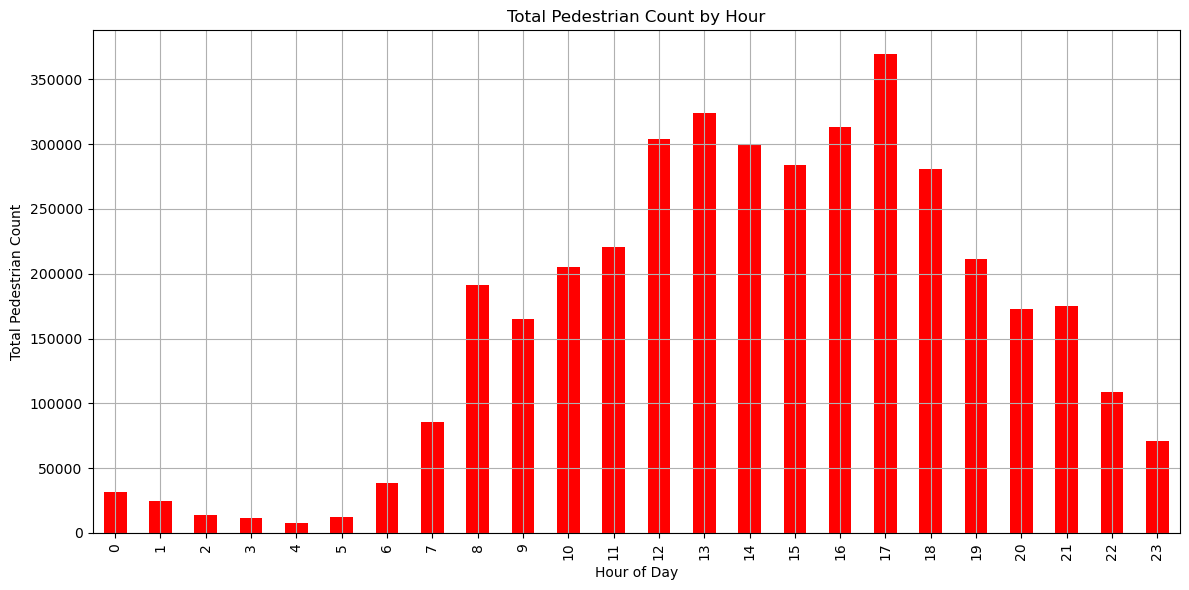

In [438]:
# Group by hour and sum pedestrian counts
hourly_counts = pedestrian_counting.groupby('hourday')['pedestriancount'].sum()

# Plot the grouped data
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', color='red')

# Add titles and labels
plt.title('Total Pedestrian Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Pedestrian Count')
plt.grid(True)
plt.tight_layout()
plt.show()


From the results we can clearly see that the hours of 13 and 17 indicating the two most busiest periods of the day. I beleive this is a good representation of lunch breaks and when work finishes for most individuals. 

#### Data Quality and Summary Statistics Overview Weather data 
1. **Missing data Check** 
    * I check the total number of missing data within each column with the sue of `.isnull().sum()`, this will indicate if there is missing data and which column does have it. 
2. **Statistical Description** 
    * To obtain a statistical summary I use the `.describe()` method. This will aid in understanding the distribution of the data and will point out any annomailies.
3. **Data Structure Summary** 
    * To obtain a statistical overview of the dataset and find outliers it is useful to implement `.info()`

In [441]:
print("Check for missing information in each column")
print(weather_stations_df .isnull().sum())
print("Statistical Description")
print(weather_stations_df .describe())
print("Data Structure Summary")
print(weather_stations_df .info())

Check for missing information in each column
device_id                 0
time                      0
rtc                       0
battery                   0
solarpanel                0
command                   0
solar                     0
precipitation             0
strikes                   0
windspeed                 0
winddirection             0
gustspeed                 0
vapourpressure            0
atmosphericpressure       0
relativehumidity          0
airtemp                   0
lat_long               9999
sensor_name            9999
dtype: int64
Statistical Description
                rtc      battery   solarpanel  command        solar  \
count  9.999000e+03  9999.000000  9999.000000   9999.0  9999.000000   
mean   9.263554e+07     4.180496    10.544423      0.0   114.478248   
std    1.745250e+07     0.025435    10.107484      0.0   199.251420   
min    5.862781e+06     4.128000     0.000000      0.0     0.000000   
25%    8.247028e+07     4.158000     0.233000      0.0     

1. ***Missing data Check*** 
    * We can see from the results obtained there is no missing data in any column, therefore no need to handle missing values. 

2. ***Statistical Description***
    * Key highlights from statiscal summary: 
    * `precipitiation`:
        - All values are zero this column holds no other value and is a good canditate to be dropped
    * `solar`: 
        - We see a very high max value of 1043 data is strongly skewed, high sunlight levels.  
        - the mean and median values are different
    * `strikes`(lightning): 
        -With a mean value of 0.0048 indicate very few events and a max of 9 indicate low lightnign occurences
    * `windspeed`, `gustspeed`, `winddirection`: 
        - All have extremely large outlier values of -9999.0. this may need to be removed to extract valuable information with similar windspeed and gustspeed averages. 
    * `relativehumidity`: 
        - has a range from 18 to 100 
    * `airtemp`: 
        - has a range from 1deg to 39.2deg celcius indicating normal weather patterns for the city of melbourne.  

3. ***Data Structure Summary*** 
    * We can see the data type of each key feature, providing us with a clear outline of what data we are dealing with. `
    * We see that the time needs to be converted to datetime format for easy time analysis. 
    * lat/lon should also be split to refelct the changes made to the previous dataset to be matched. 

In [443]:
weather_stations_df
# Create a new row named latitude
weather_stations_df['latitude'] = weather_stations_df['lat_long'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
# Create a new row named longitude
weather_stations_df['longitude'] = weather_stations_df['lat_long'].apply(lambda x: x['lon'] if isinstance(x, dict) else None)

weather_stations_df.head()

device_id                       time        rtc  battery  solarpanel  \
0  atmos41-32fc  2025-08-16T20:40:34+00:00  121366929    4.140       1.458   
1  atmos41-32fc  2025-08-16T21:10:53+00:00  121368748    4.137      19.340   
2  atmos41-32fc  2025-08-16T20:10:00+00:00  121365095    4.140       0.225   
3  atmos41-32fc  2025-08-17T00:11:54+00:00  121379609    4.208      22.161   
4  atmos41-32fc  2025-08-17T02:26:30+00:00  121387685    4.209      22.064   

   command  solar  precipitation  strikes  windspeed  winddirection  \
0        0      0              0        0       1.38          174.9   
1        0      3              0        0       1.55          170.9   
2        0      0              0        0       1.52          171.7   
3        0    140              0        0       1.05          155.4   
4        0    175              0        0       0.89          152.1   

   gustspeed  vapourpressure  atmosphericpressure  relativehumidity  airtemp  \
0       2.11            0.74               101.18                86      4.8   
1       2.32            0.73               101.22                86      4.6   
2       2.44            0.74               101.16                86      4.8   
3       2.67            0.91               101.33                83      8.3   
4       2.80            1.01               101.32                67     13.2   

  lat_long sensor_name latitude longitude  
0     None        None     None      None  
1     None        None     None      None  
2     None        None     None      None  
3     None        None     None      None  
4     None        None     None      None

In [444]:

#list all sensor names 
print(weather_stations_df['sensor_name'].nunique()) 
#list all location 
print(weather_stations_df['latitude'].nunique()) 
print(weather_stations_df['longitude'].nunique()) 

0
0
0


The results indicate that each of these only have one unique varaible indicating no variance in the data. This means there is only one sensor in one location 
this information indicates that sensor name and dev id are not of value to the AI pedestrain flow prediction. 

### Dropping Unnecessary Columns 
To clean the dataset redundant information is dropped the columns dropped are: 

- **`dev_id`**: A unique identifier for the weather station device however provided there is only one device it will not be necessary and will not contribute any valueable information. 
- **`sensor_name`** Another label for the dev_id this information does not contribute to implementing AI pedestrian flow predictor. 
- **`lat_long`** The location is seperated into longitude and latitude columns and is no longer necessary, also there is only one location utilised. 

In [447]:
weather_stations_df.drop(columns=['device_id', 'sensor_name', 'lat_long'], inplace=True) 
weather_stations_df['date_time'] = pd.to_datetime(weather_stations_df['time'])
weather_stations_df.head()

time        rtc  battery  solarpanel  command  solar  \
0  2025-08-16T20:40:34+00:00  121366929    4.140       1.458        0      0   
1  2025-08-16T21:10:53+00:00  121368748    4.137      19.340        0      3   
2  2025-08-16T20:10:00+00:00  121365095    4.140       0.225        0      0   
3  2025-08-17T00:11:54+00:00  121379609    4.208      22.161        0    140   
4  2025-08-17T02:26:30+00:00  121387685    4.209      22.064        0    175   

   precipitation  strikes  windspeed  winddirection  gustspeed  \
0              0        0       1.38          174.9       2.11   
1              0        0       1.55          170.9       2.32   
2              0        0       1.52          171.7       2.44   
3              0        0       1.05          155.4       2.67   
4              0        0       0.89          152.1       2.80   

   vapourpressure  atmosphericpressure  relativehumidity  airtemp latitude  \
0            0.74               101.18                86      4.8     None   
1            0.73               101.22                86      4.6     None   
2            0.74               101.16                86      4.8     None   
3            0.91               101.33                83      8.3     None   
4            1.01               101.32                67     13.2     None   

  longitude                 date_time  
0      None 2025-08-16 20:40:34+00:00  
1      None 2025-08-16 21:10:53+00:00  
2      None 2025-08-16 20:10:00+00:00  
3      None 2025-08-17 00:11:54+00:00  
4      None 2025-08-17 02:26:30+00:00

### Visualising weather station df  

A line plot will be utilised to be able to observe air tempreture over time.  

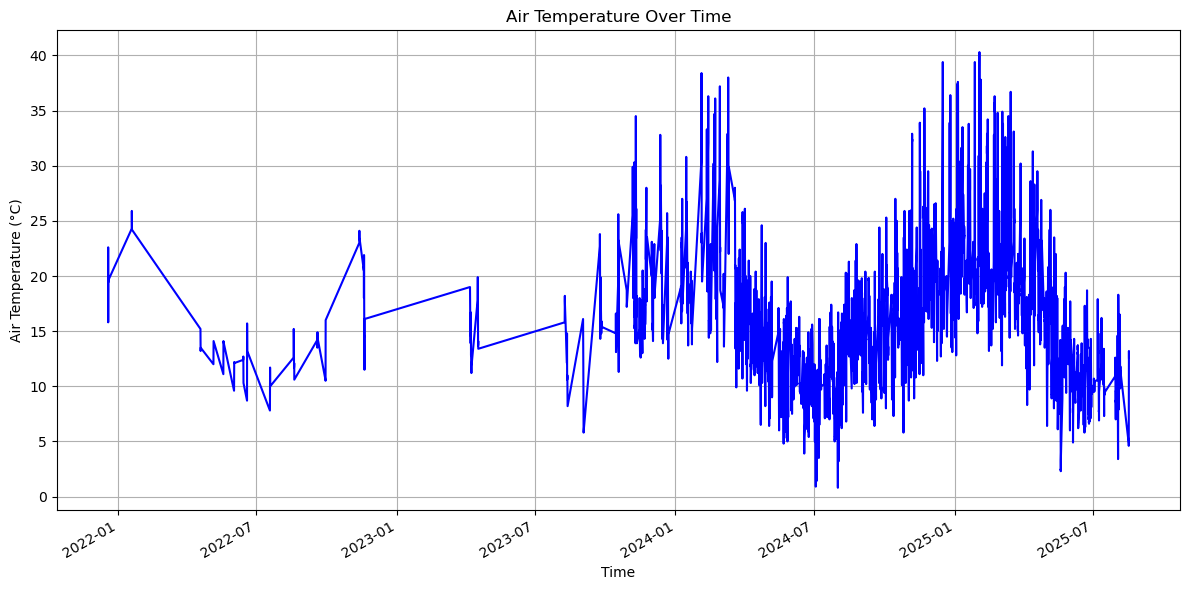

In [449]:
# change time format to be updated
weather_stations_df['time'] = pd.to_datetime(weather_stations_df['time'])

# groupby airtemp by time with average tempreture 
temperature_time = weather_stations_df.groupby('time')['airtemp'].mean()

# Visualing a line graph 
plt.figure(figsize=(12, 6))
temperature_time.plot(color='blue')

plt.title('Air Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Air Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

***Air Temperature Over Time*** 

Analysing the results obtained, it is clearly  that there is less significant data before 2024-01, as the number of data points are quite low, inidcating data collection frequency during this time was lower than expected. However, the general trend of the data seems to be consistent with the higher frequency data, indicating tempreture has increased in summer and decreases in winter. 

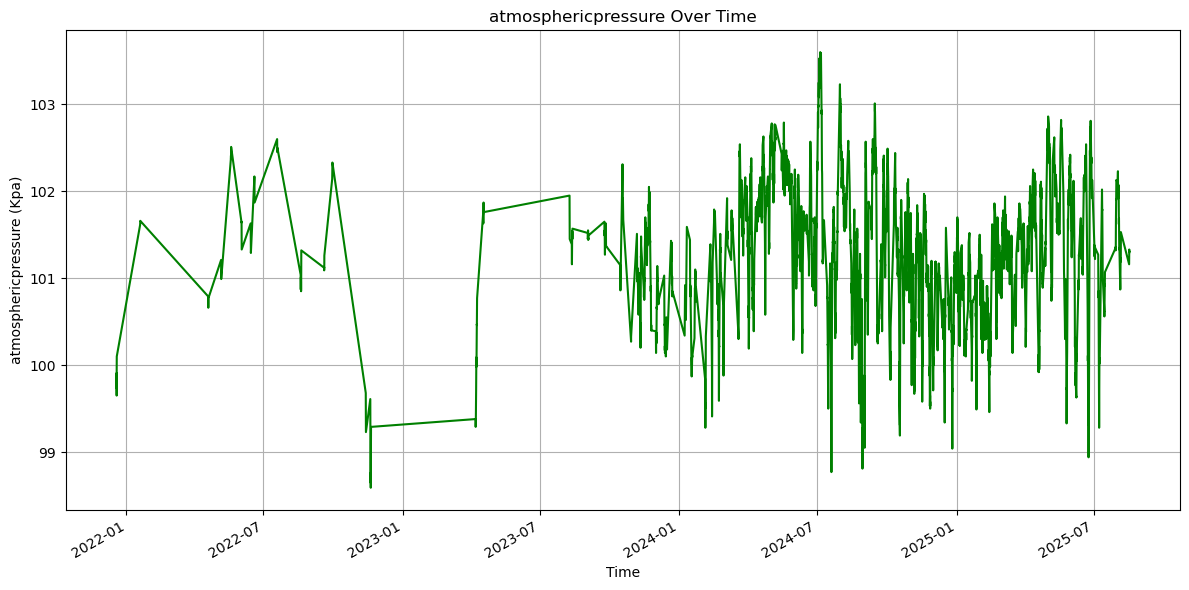

In [451]:
# Convert 'time' to datetime format
weather_stations_df['time'] = pd.to_datetime(weather_stations_df['time'])

# groupby time 
temperature_time = weather_stations_df.groupby('time')['atmosphericpressure'].mean()

# Plotting
plt.figure(figsize=(12, 6))
temperature_time.plot(color='green')

plt.title('atmosphericpressure Over Time')
plt.xlabel('Time')
plt.ylabel('atmosphericpressure (Kpa)')
plt.grid(True)
plt.tight_layout()
plt.show()

***Atmospheric Pressure Over Time*** 

Analysing the results obtained, it is clearly  that there is less significant data before 2024-01, as the number of data points are quite low, inidcating data collection frequency during this time was lower than expected. However, the general trend of the data seems to be consistent with the more recent data similar to the data represented in Air tempreture. 

#### Uniform Date time 
`pedestrian_hourly` the pedestrian counting dataset with just date_time and pedestrian count. Utilised for visulaising the relationship between pedestrian count and various weather metrics.
Enusre `date_time` is uniform in both datasets to be able to merge. 

In [454]:
pedestrian_hourly = pedestrian_counting.groupby('date_time')['hourday'].sum().reset_index()
pedestrian_hourly.columns = ['date_time', 'pedestrian_count']


In [455]:
pedestrian_hourly['date_time'] = pedestrian_hourly['date_time'].dt.tz_localize(None).dt.floor('h')
weather_stations_df['date_time'] = weather_stations_df['date_time'].dt.tz_localize(None).dt.floor('h')


### Visualising weather station features against Pedestrian count 

All key features are visually examined against pedestrian count, this is done by merging the datasets into the `combined_df` 

<Figure size 1200x1000 with 0 Axes>

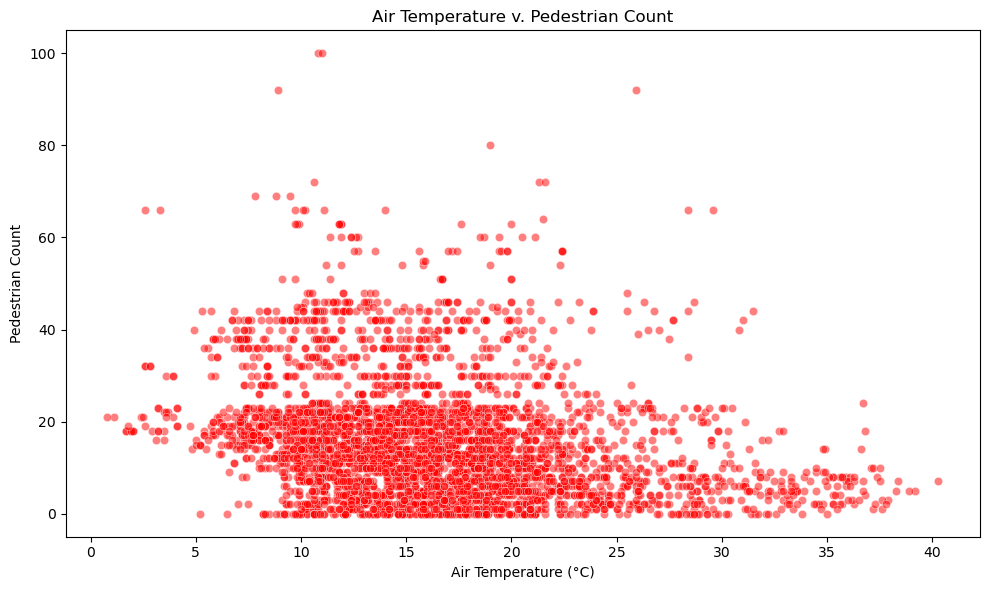

In [457]:
plt.figure(figsize= (12, 10))

#create a combined dataset of pedestrian and weather data merge by date_time 
combined_df = pd.merge(pedestrian_hourly, weather_stations_df, on= 'date_time', how= 'inner')

# Scatterplot air temperature vs pedestrian Count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='airtemp', y='pedestrian_count', alpha=0.5, color = 'red')
plt.title("Air Temperature v. Pedestrian Count")
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Pedestrian Count")
plt.tight_layout()
plt.show()





***Air Temperature vs Pedestrian Count*** 

Analysing the results obtained in the scatterplot, data is grouped around the 10&deg;C and 25&deg;C range. The pedestrian count range is clustered around 0-20, and smaller distribution of higher pedestrian count with the peak count values within 10&deg;C and 25&deg;C range. From this scatterplot, it inidicates that more moderate tempretures result in increased pedestrian activity, with the extreme tempretures, that is less than 5&deg;C and greater than 30&deg;C having a clear negative correlation with pedestrian count. 
The relationship is indicative of a quadratic relationship as both low and high tempretures have lower pedestrian count values and highest pedestrian count exists within moderate temperature values.


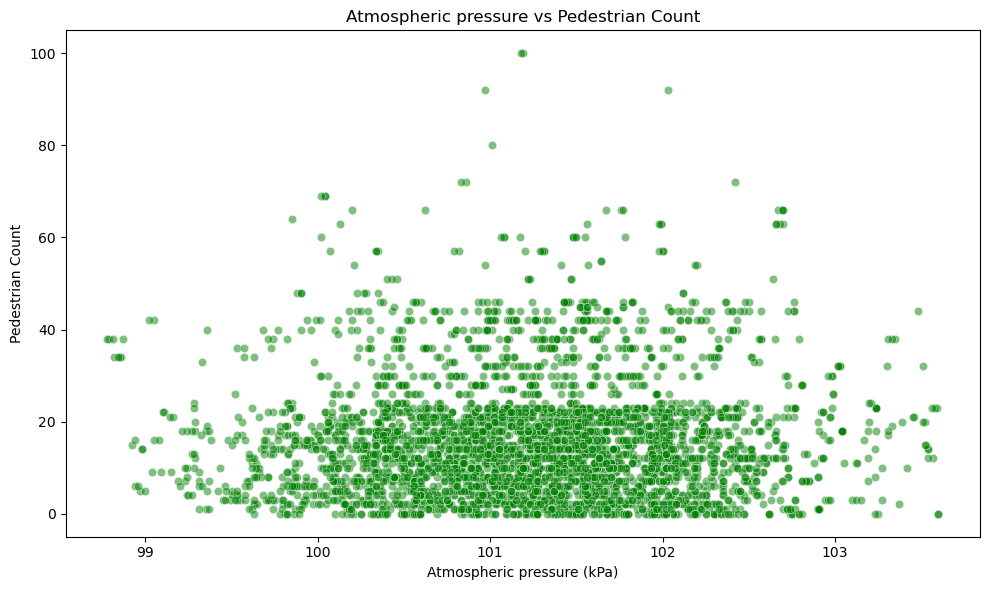

In [459]:
# Scatterplot atmospheric pressue vs pedestrian count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='atmosphericpressure', y='pedestrian_count', alpha=0.5, color = 'green')
plt.title("Atmospheric pressure vs Pedestrian Count")
plt.xlabel("Atmospheric pressure (kPa)")
plt.ylabel("Pedestrian Count")
plt.tight_layout()
plt.show()

***Atmospheric Pressure vs Pedestrian Count*** 

Analysing the results obtained in the scatterplot for Atmospheric Pressure vs Pedestrian Count, we can see the range is between 99 to 103 kPa. From this data no clear linear relationship can be distinguised. Indicating Atmospheric Pressure alone is not a strong predictor, would be best not to include in the model as it may incorporate noise into the models performance. 


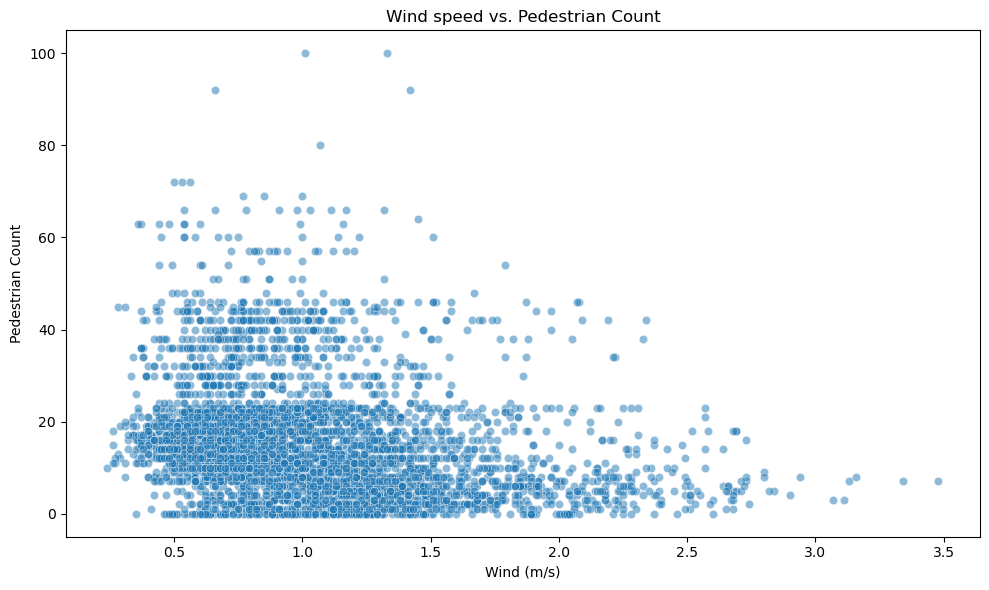

In [461]:
# Scatterplot windspeed vs pedestrian Count
combined_df = combined_df[combined_df['windspeed'] > -100]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='windspeed', y='pedestrian_count', alpha=0.5)
plt.title("Wind speed vs. Pedestrian Count")
plt.xlabel("Wind (m/s)")
plt.ylabel("Pedestrian Count")
plt.tight_layout()
plt.show()

***Wind Speed vs Pedestrian Count*** 

Analysing the results obtained in the scatterplot, data is grouped between 0.5m/s and 1.5m/s. The peak pedestrian traffic also occurs during that range, with a significant decrease in pedestrian count as wind speed increases. People tend to prefer walking in calmer weather and high wind speeds deters pedestrian foot traffic. There is a clear negative linear relationship between the two features and this data inidicates wind speed will be useful for predicitive modeling. 


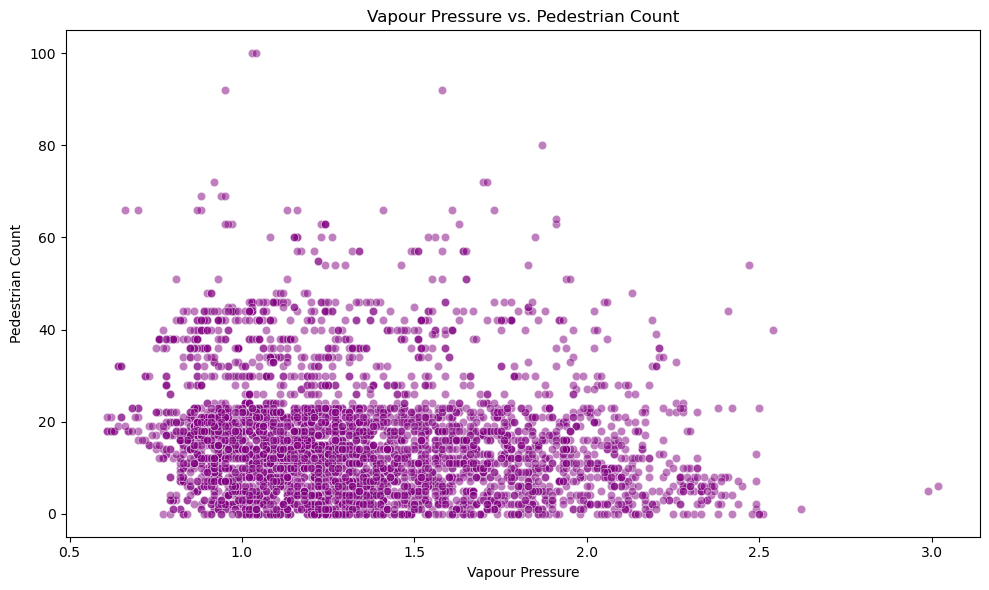

In [463]:

#Scatterplot vapourpressure vs pedestrian count 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='vapourpressure', y='pedestrian_count', alpha=0.5, color = 'purple')
plt.title("Vapour Pressure vs. Pedestrian Count")
plt.xlabel("Vapour Pressure")
plt.ylabel("Pedestrian Count")
plt.tight_layout()
plt.show()


***Vapour Pressure vs Pedestrian Count*** 

Analysing the results obtained in the scatterplot, There does not seem to be a strong relationship between vapour pressure and foot traffic, we do see a slight decrease in foot traffic as vapour pressure increases, indicating less people walk in more humid climates, however, it is not a strong enough correlation on its own may be effective on improving the models performance when combined with another feature. 

### Correlation matrix 
A correlation matrix is an effective method to represent the linear relationship between features in a dataset. It is an essential tool utlitised in feature engineeringm as it aids in identifying how strongly features are correlated with each other, find features that have strong correlation with the target variable and importantly enable the detection of multicolinearlity in which two features are highly similar and hence may reduce the perfromance of the ML model. 
1) Combine the features into a singular dataset.
   All relavent features are moved into a singular dataset. 
3) Implement and visualise the correlation matrix. 


In [466]:
combined_data = combined_df.drop(columns=['date_time', 'time', 'command', 'precipitation', 'longitude','latitude'])

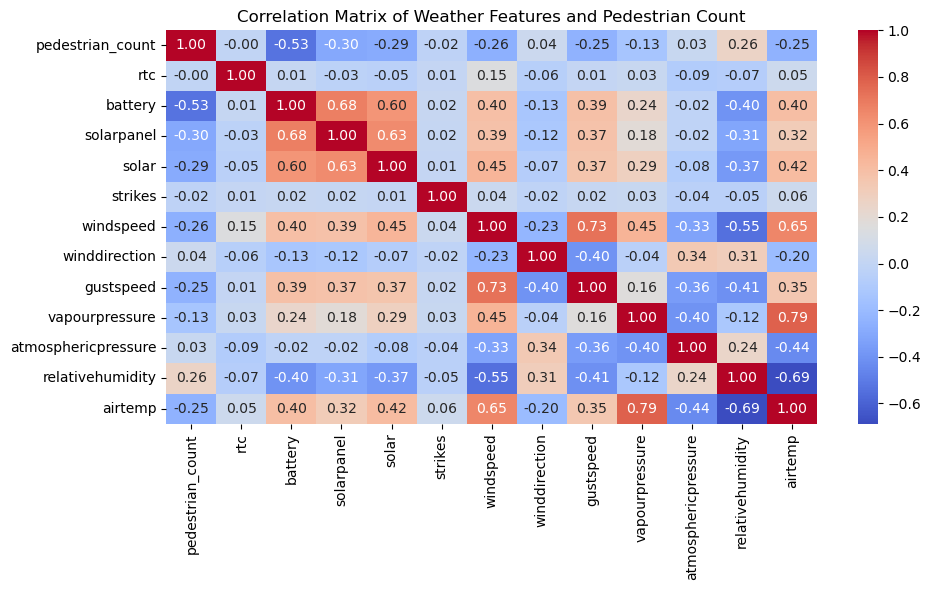

In [467]:
# Coreelation matrix strucutre 
c_matrix = combined_data.corr()

# visualisation of the matrix 
plt.figure(figsize=(10, 6))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Weather Features and Pedestrian Count")
plt.tight_layout()
plt.show()

***Correlation matrix***

The correlation matrix allows us to determine the linear relationship between two feature pairs by anaysling the values it will allow us to determine, which features have a high correlation with pedestrian count and which features, do not. This will also enable us to determine how similiar featrues are to each other. The values range from 1 to -1, indicating a positive linear relationship between two features, the values -1 is indicative of a negitive linear relationship between the two features. A value of 0 indicates no linear corrleation between the two features or as such the relationship cannot be captured linearly. By imploring the correlation matrix it has enabled a visual representation of how each feature correlates to the the target variable pedestrian count. 

**Most Important Features**

Determined on correlation value and practical application, the key features to consider are: 
1) relativehumidity 
2) windspeed 
3) airtemp 
4) gustspeed 
5) vapourpressure 
6) atmosphericpressure 

#### Data Quality and Summary Statistics Overview Venue data 
1. **Missing data Check** 
    * I check the total number of missing data within each column with the sue of `.isnull().sum()`, this will indicate if there is missing data and which column does have it. 
2. **Statistical Description** 
    * To obtain a statistical summary I use the `.describe()` method. This will aid in understanding the distribution of the data and will point out any annomailies.
3. **Data Structure Summary** 
    * To obtain a statistical overview of the dataset and find outliers it is useful to implement `.info()`

In [470]:
print("Check for missing information in each column")
print(venue_location.isnull().sum())
print("Statistical Description")
print(venue_location.describe())
print("Data Structure Summary")
print(venue_location.info())

Check for missing information in each column
geo_point_2d      0
geo_shape         0
prop_id           0
no_smoking        0
level_1_na        0
addresspt1        0
event             0
full_name         0
addressp_1        0
training          0
dog_prohib        0
dog_off_le        0
venue_recn        0
addresspt         0
sport           139
promotion       206
bookable          0
level_3_na      192
wedding           0
roadseg_id        0
sustainabi       18
level_2_na        0
latitude          0
longitude         0
dtype: int64
Statistical Description
         latitude   longitude
count  206.000000  206.000000
mean   -37.810742  144.963473
std      0.017024    0.016949
min    -37.844590  144.913667
25%    -37.821651  144.954027
50%    -37.812328  144.968012
75%    -37.798513  144.976381
max    -37.778101  144.989091
Data Structure Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype

1. ***Missing data Check*** 
    * We can see from the results obtained there are multiple columns with missing data.
    * Columns with missing data:
      - `sport`, with a total of 139 missing values
      - `promotion`, with a total of 266 missing values
      - `level_3_na`, with a total of 192 missing values
      - `sustainabi`, with 18 missing values
      - The remaining columns all have 0 missing values

2. ***Data Structure Summary*** 
    * Most data is of type object, indicating there may be many categorical data types within this dataset that will need to be changing  into numerical.
    * latitude and longitude, are of type float and are centered around melbourne. 

### Converting categorical data to numerical.
The for loop, loops throught the features in the venue_locations dataset. Given the data in the column is catergorical Y or N it will convert the values to the respective 1 and 0. 
This is important as ML models cannot understand categorical data. It is important to convert them into numerical data. 

In [473]:
#converting categorical features in venue location to numerical for Y/N to 1/0 
for col in ['event', 'wedding', 'sport', 'bookable', 'dog_prohib','training', 'dog_off_le', 'no_smoking']:
    venue_location[col] = venue_location[col].apply(lambda x: 1 if str(x).strip().upper() == 'Y' else 0) 

venue_location

geo_point_2d  \
0    {'lon': 144.98896595113547, 'lat': -37.8171274...   
1    {'lon': 144.98293613155118, 'lat': -37.8425742...   
2    {'lon': 144.9554621837315, 'lat': -37.78557214...   
3    {'lon': 144.98286097598913, 'lat': -37.8445902...   
4    {'lon': 144.97660241098285, 'lat': -37.8246014...   
..                                                 ...   
201  {'lon': 144.96425597799097, 'lat': -37.8203799...   
202  {'lon': 144.98183534800913, 'lat': -37.8398571...   
203  {'lon': 144.98036176101897, 'lat': -37.8420796...   
204  {'lon': 144.9574659757651, 'lat': -37.78883624...   
205  {'lon': 144.93911928904672, 'lat': -37.7963584...   

                                             geo_shape prop_id  no_smoking  \
0    {'type': 'Feature', 'geometry': {'coordinates'...       0           0   
1    {'type': 'Feature', 'geometry': {'coordinates'...  103756           0   
2    {'type': 'Feature', 'geometry': {'coordinates'...  107426           0   
3    {'type': 'Feature', 'geometry': {'coordinates'...  103756           0   
4    {'type': 'Feature', 'geometry': {'coordinates'...  108615           0   
..                                                 ...     ...         ...   
201  {'type': 'Feature', 'geometry': {'coordinates'...  111302           0   
202  {'type': 'Feature', 'geometry': {'coordinates'...  103756           0   
203  {'type': 'Feature', 'geometry': {'coordinates'...  103756           0   
204  {'type': 'Feature', 'geometry': {'coordinates'...  110940           0   
205  {'type': 'Feature', 'geometry': {'coordinates'...  106339           0   

               level_1_na   addresspt1  event  \
0    Other Park Locations  29.98397741      1   
1            Fawkner Park          0.0      0   
2              Royal Park          0.0      0   
3            Fawkner Park          0.0      1   
4            Kings Domain          0.0      1   
..                    ...          ...    ...   
201    Promotional Spaces    81.022573      1   
202          Fawkner Park   3.99128603      0   
203          Fawkner Park          0.0      0   
204  Other Park Locations   39.4869707      1   
205  Other Park Locations  42.40450422      1   

                                             full_name addressp_1  training  \
0                Other Park Locations:  Weedon Reserve         77         0   
1          Fawkner Park:  FP - Cordner_T1_T2_T3_F2_Ct3          0         0   
2             Royal Park:  RP - Lawn 6_Walker East_Ct2          0         0   
3                    Fawkner Park:  FP - Lawn 21_T8_S3          0         1   
4         Kings Domain:  KD - Lawn 9/Pillars of Wisdom          0         1   
..                                                 ...        ...       ...   
201            Promotional Spaces:  Southbank Spillway        360         0   
202         Fawkner Park:  FP - Northern Pavilion East        111         0   
203       Fawkner Park:  FP - Lawn 19 South_ T4_Ct5_S6          0         0   
204  Other Park Locations:  Clunies Ross Reserve (T...        264         0   
205             Other Park Locations:  Clayton Reserve         64         0   

     ...  sport  promotion bookable level_3_na  wedding roadseg_id  \
0    ...      0       None        1       None        0      21951   
1    ...      1       None        1       None        0          0   
2    ...      1       None        1       None        0          0   
3    ...      1       None        1       None        0          0   
4    ...      0       None        1       None        1          0   
..   ...    ...        ...      ...        ...      ...        ...   
201  ...      0       None        1       None        0          0   
202  ...      1       None        1       None        0          0   
203  ...      1       None        1       None        0          0   
204  ...      0       None        1       None        0          0   
205  ...      0       None        1       None        0          0   

     sustainabi              

### Dropping Unnecessary Columns 
To clean the dataset redundant information is dropped the columns dropped are: 

- **`geo_point_2d`**:Redundant with latitude and longitude
- **`geo_shape`** :Complex geometry not usable in standard ML pipelines 
- **`level_1_na`** unnecessary data 
- **`addresspt1`**: Textual address; not informative for ML
- **`addresspt`** unnecessary data 
- **`level_3_na`** unnecessary data 
- **`roadseg_id`** Categorical ID with no predictive signal unless joined with external dataset
- **`sustainabi`** Has no significance, in capturing pedestrian count 
- **`level_2_na`** unnecessary data 

In [475]:
print(venue_location.columns)
venue_location.drop(['geo_point_2d','geo_shape', 'level_1_na', 'addresspt1', 'addresspt','level_3_na', 'roadseg_id', 'sustainabi','level_2_na'], axis=1, inplace=True) 
venue_location

Index(['geo_point_2d', 'geo_shape', 'prop_id', 'no_smoking', 'level_1_na',
       'addresspt1', 'event', 'full_name', 'addressp_1', 'training',
       'dog_prohib', 'dog_off_le', 'venue_recn', 'addresspt', 'sport',
       'promotion', 'bookable', 'level_3_na', 'wedding', 'roadseg_id',
       'sustainabi', 'level_2_na', 'latitude', 'longitude'],
      dtype='object')


prop_id  no_smoking  event  \
0         0           0      1   
1    103756           0      0   
2    107426           0      0   
3    103756           0      1   
4    108615           0      1   
..      ...         ...    ...   
201  111302           0      1   
202  103756           0      0   
203  103756           0      0   
204  110940           0      1   
205  106339           0      1   

                                             full_name addressp_1  training  \
0                Other Park Locations:  Weedon Reserve         77         0   
1          Fawkner Park:  FP - Cordner_T1_T2_T3_F2_Ct3          0         0   
2             Royal Park:  RP - Lawn 6_Walker East_Ct2          0         0   
3                    Fawkner Park:  FP - Lawn 21_T8_S3          0         1   
4         Kings Domain:  KD - Lawn 9/Pillars of Wisdom          0         1   
..                                                 ...        ...       ...   
201            Promotional Spaces:  Southbank Spillway        360         0   
202         Fawkner Park:  FP - Northern Pavilion East        111         0   
203       Fawkner Park:  FP - Lawn 19 South_ T4_Ct5_S6          0         0   
204  Other Park Locations:  Clunies Ross Reserve (T...        264         0   
205             Other Park Locations:  Clayton Reserve         64         0   

     dog_prohib  dog_off_le venue_recn  sport promotion  bookable  wedding  \
0             0           0        402      0      None         1        0   
1             0           0       1354      1      None         1        0   
2             0           0        277      1      None         1        0   
3             0           1         67      1      None         1        0   
4             0           0        184      0      None         1        1   
..          ...         ...        ...    ...       ...       ...      ...   
201           0           0        823      0      None         1        0   
202           0           0       1355      1      None         1        0   
203           0           1         74      1      None         1        0   
204           0           0        352      0      None         1        0   
205           0           1        351      0      None         1        0   

      latitude   longitude  
0   -37.817127  144.988966  
1   -37.842574  144.982936  
2   -37.785572  144.955462  
3   -37.844590  144.982861  
4   -37.824601  144.976602  
..         ...         ...  
201 -37.820380  144.964256  
202 -37.839857  144.981835  
203 -37.842080  144.980362  
204 -37.788836  144.957466  
205 -37.796358  144.939119  

[206 rows x 15 columns]

### Geospatial Visualisation of Venue Location and Pedestrian Sensor location.   

This follium graph will represent the visual markers of all of the venue locations across melbourne, this will enable us to see the spread of location venues. The graph also has visual representation of the pedestrian count sensor locations, enabling a clear representation of the the spread of venue and pedestrian sensors and how they correlate. 
Aiding in better understanding the problem. 

In [477]:
import folium
#centre the map on Melbourne 
m = folium.Map(location=[-37.8136, 144.9631], zoom_start= 14) 
#iterate over the rows in venue location 
for _, row in venue_location.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color='blue',
            fill=True
        ).add_to(m)
        
for _, row in pedestrian_counting.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color='yellow',
            fill=True
        ).add_to(m)

# Add legend
legend_html = """
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: 100px;
            background-color: rgba(255, 255, 255, 0.8); border:2px solid grey; z-index:1000; font-size:12px;
            padding: 10px;">
<b>Legend</b><br>
<i style="background:blue; width:10px; height:10px; display:inline-block; border-radius:50%;"></i>&nbsp;Venue Location<br>
<i style="background:yellow; width:10px; height:10px; display:inline-block; border-radius:50%;"></i>&nbsp;Pedestrian Counter<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
m

### Visualisation Summary of Spatial Data

The output generated is an interactive map of the Melbourne CBD featuring:

- **Yellow dots**: Pedestrian counter 
- **Blue dots**: Venue Locations  

From the map, several key insights can be drawn:

- Pedestrian sensors are installed only at specific points, which means that pedestrian traffic data is not uniformly available city-wide.
- Venue Locations, tend to surround the city and only few venue location have a sensor within a close distance, this does pose the difficulty of accuratly determining the pedestrian count at the venue locations.  
- This limitation inidcates, the necessity to utilise various metrics to capture relationships with pedestrian count and be able to provide a reliable output. 
- Visualising this spatial data has proven to be highly informative it provides critical context to the effective design and implementation of the AI pedestrian flow use case. 



### Calculating Distance from Venue to Pedestrian count 
Utilising GeoPy, which is a python library that makes geographical calculations on distance in this case between the Venue location and each pedestrian sensor, this will be a key feature in determining the pedestrian count at the venue location as the venue lcoation data does not contain pedestrian sensors at the location or historical time data. 

In [522]:
from geopy.distance import geodesic 
# store the distance values and the other essential features 
distance_rows = [] 
# for loop, loops through each venue in venue location and assigned the value to the name 
for _, venue in venue_location.iterrows():
    venue_loc = (venue['latitude'], venue['longitude'])
    venue_id = venue['prop_id'] 
    venue_name = venue['full_name'] 
    sport = venue['sport']
    wedding = venue['wedding']
    bookable = venue['bookable']
    no_smoking = venue['no_smoking']
    event = venue['event']
    training = venue['training']
    dog_prohib = venue['dog_prohib']

    # the secondary loop, loops through pedestrian count and caclulates the distance 
    for _, sensor in pedestrian_counting.iterrows(): 
        sensor_loc = (sensor['latitude'], sensor['longitude'])
        sensor_id = sensor['location_id'] 
        # The distance is calculated using geodesic venue location and sensor locaiton. 
        distance = geodesic(venue_loc, sensor_loc).meters 
        # the data is then appended to the distance_rows list 
        distance_rows.append({'venue_id': venue_id, 'venue_name': venue_name, 'sensor_id': sensor_id, 'distance_venue': distance, 
                              'sport': sport, 'wedding': wedding, 'bookable':bookable, 'no_smoking':no_smoking, 'event': event,
                              'training': training, 'dog_prohib': dog_prohib} )
#distance_rows is converted into pandas dataframe and renamed under venue_sensor_distance 
venue_sensor_distance = pd.DataFrame(distance_rows)

venue_sensor_distance

venue_id                              venue_name  sensor_id  \
0              0   Other Park Locations:  Weedon Reserve         45   
1              0   Other Park Locations:  Weedon Reserve        143   
2              0   Other Park Locations:  Weedon Reserve        135   
3              0   Other Park Locations:  Weedon Reserve        132   
4              0   Other Park Locations:  Weedon Reserve        107   
...          ...                                     ...        ...   
2059789   106339  Other Park Locations:  Clayton Reserve          3   
2059790   106339  Other Park Locations:  Clayton Reserve         69   
2059791   106339  Other Park Locations:  Clayton Reserve         70   
2059792   106339  Other Park Locations:  Clayton Reserve         75   
2059793   106339  Other Park Locations:  Clayton Reserve         41   

         distance_venue  sport  wedding  bookable  no_smoking  event  \
0           2041.037503      0        0         1           0      1   
1           2984.422190      0        0         1           0      1   
2           3150.032923      0        0         1           0      1   
3           3130.019230      0        0         1           0      1   
4           2870.414624      0        0         1           0      1   
...                 ...    ...      ...       ...         ...    ...   
2059789     2749.919950      0        0         1           0      1   
2059790     3258.639391      0        0         1           0      1   
2059791     1288.568030      0        0         1           0      1   
2059792     3762.527619      0        0         1           0      1   
2059793     3327.852703      0        0         1           0      1   

         training  dog_prohib  
0               0           0  
1               0           0  
2               0           0  
3               0           0  
4               0           0  
...           ...         ...  
2059789         0           0  
2059790         0           0  
2059791         0           0  
2059792         0           0  
2059793         0           0  

[2059794 rows x 11 columns]

The process of calculating the distance to each sensor from the venue has significantly increased the size fo the dataframe, a lot of this information is not relavent as we are only concerned about the resutls obtained by the pedestrian sensor closest to the venue. I will then group the data and only keep the shortest distance from each venue to the closest sensor. 

### Nearest Sensor Calculation  
The data is grouped by venue id then the shortest distance is calculated utilising `idxmin()`

In [508]:
# Select the row with the minimum distance for each venue_id
nearest_sensors = venue_sensor_distance.loc[venue_sensor_distance.groupby('venue_id')['distance_venue'].idxmin()].reset_index(drop=True)

nearest_sensors


venue_id                                         venue_name  sensor_id  \
0         0  Promotional Spaces:  Melbourne Central Station...         66   
1    100385            Alexandra Gardens:  AG - Henley Landing        136   
2    100514  Other Park Locations:  North Melbourne Recreat...        180   
3    100894         Other Park Locations:  Bayswater Road Park         85   
4    101101     Alexandra Gardens:  AG - Lawn2/Peppercorn Lawn         29   
..      ...                                                ...        ...   
75   622440                 Docklands:  Parks:  Victoria Green        137   
76   624055       Other Park Locations:  Normanby Road Reserve         25   
77   624154     Docklands:  All Other Spaces:  Australia Wharf          8   
78   632876                      Docklands:  Parks:  Quay Park         11   
79   651910                     Docklands:  Parks:  Buluk Park        130   

    distance_venue  sport  wedding  bookable  no_smoking  event  training  \
0        62.590427      0        0         1           0      0         0   
1       347.445537      0        0         1           0      1         0   
2       696.844279      0        0         1           0      1         0   
3       528.924036      0        0         1           1      1         0   
4        60.177471      0        0         1           0      1         1   
..             ...    ...      ...       ...         ...    ...       ...   
75      181.488320      0        0         1           0      1         0   
76      299.618488      0        0         1           0      1         0   
77      116.893047      0        0         1           0      1         0   
78      187.052121      0        0         1           0      1         0   
79       49.092892      0        0         1           0      1         0   

    dog_prohib  
0            0  
1            0  
2            0  
3            0  
4            0  
..         ...  
75           0  
76           0  
77           0  
78           0  
79           0  

[80 rows x 11 columns]

When analysing the shape of the matrix we can see that it has decreased significantly from the 2059794 rows to 80.

In [530]:
print(pedestrian_counting.columns)

Index(['location_id', 'sensing_date', 'hourday', 'direction_1', 'direction_2',
       'pedestriancount', 'latitude', 'longitude', 'date_time'],
      dtype='object')


### Merging Datasets 
The final dataset is created by merging pdestrianc count, nearest_senor(venue data) and weather data. 
Merge pedestrian count with nearest sensor left on location id and right on sensor id with inner join. 
Next model_df is merged with weather station data on date_time with inner join. The purpose is to combine all the datasets to extract the key features to be able to apply predicitive models. 

In [528]:
# Merge pedestrian count with nearest sensor left on location id and right on sensor id with inner join. 
model_df = pd.merge(
    pedestrian_counting, 
    nearest_sensors, 
    left_on='location_id', right_on='sensor_id', 
    how='inner'
)

# model_df is merged with weather station data on date_time with inner join
model_df = pd.merge(
    model_df,
    weather_stations_df,
    on='date_time',
    how='inner'
)

model_df

location_id sensing_date  hourday  direction_1  direction_2  \
0             143   2025-03-25       16          221          221   
1             130   2024-08-15        7            3            4   
2             130   2024-08-15        7            3            4   
3             130   2024-08-15        7            3            4   
4             109   2024-10-19       15          107          162   
...           ...          ...      ...          ...          ...   
4702           12   2024-02-21       19          266          231   
4703           12   2024-02-21       19          266          231   
4704           12   2024-02-21       19          266          231   
4705           25   2024-07-02        3            0            0   
4706           25   2024-07-02        3            0            0   

      pedestriancount  latitude_x  longitude_x           date_time venue_id  \
0                 442  -37.821728   144.955570 2025-03-25 16:00:00   611396   
1                   7  -37.820464   144.941268 2024-08-15 07:00:00   604120   
2                   7  -37.820464   144.941268 2024-08-15 07:00:00   611697   
3                   7  -37.820464   144.941268 2024-08-15 07:00:00   651910   
4                 269  -37.811937   144.956211 2024-10-19 15:00:00   102942   
...               ...         ...          ...                 ...      ...   
4702              497  -37.814580   144.942924 2024-02-21 19:00:00   579369   
4703              497  -37.814580   144.942924 2024-02-21 19:00:00   579369   
4704              497  -37.814580   144.942924 2024-02-21 19:00:00   579369   
4705                0  -37.824018   144.956044 2024-07-02 03:00:00   624055   
4706                0  -37.824018   144.956044 2024-07-02 03:00:00   624055   

      ... strikes  windspeed  winddirection  gustspeed  vapourpressure  \
0     ...       0       1.01          170.6       1.88            1.71   
1     ...       0       0.95          141.0       2.72            1.52   
2     ...       0       0.95          141.0       2.72            1.52   
3     ...       0       0.95          141.0       2.72            1.52   
4     ...       0       1.03          194.6       2.72            1.31   
...   ...     ...        ...            ...        ...             ...   
4702  ...       0       0.72          169.1       2.10            1.64   
4703  ...       0       0.79          169.4       1.81            1.64   
4704  ...       0       0.83          168.7       1.51            1.65   
4705  ...       0       1.11          170.5       2.78            0.80   
4706  ...       0       1.11          170.5       2.78            0.80   

      atmosphericpressure  relativehumidity  airtemp  latitude_y  longitude_y  
0                  101.62                86     17.5        None         None  
1                  100.86                65     20.0        None         None  
2                  100.86                65     20.0        None         None  
3                  100.86                65     20.0        None         None  
4                  101.68                82     14.0        None         None  
...                   ...               ...      ...         ...          ...  
4702               100.35                61     22.4        None         None  
4703               100.34                61     22.4        None         None  
4704               100.34                61     22.4        None         None  
4705               102.77                61     11.1        None         None  
4706               102.77                61     11.1        None         None  

[4707 rows x 37 columns]

### Cleaning Model_df 
This process, is the final removal of all features that do not provide any valuable insight into prediciting pedestrian count. It removes unecessary data and cleans the dataset. 

In [532]:
model_df.drop(['direction_1','direction_2', 'rtc', 'solarpanel', 'command', 'solar', 'precipitation', 'strikes', 'time','latitude_x', 'longitude_x', 'latitude_y', 'longitude_y', 'sensor_id', 'venue_name'  ], axis = 1, inplace=True)
model_df

location_id sensing_date  hourday  pedestriancount           date_time  \
0             143   2025-03-25       16              442 2025-03-25 16:00:00   
1             130   2024-08-15        7                7 2024-08-15 07:00:00   
2             130   2024-08-15        7                7 2024-08-15 07:00:00   
3             130   2024-08-15        7                7 2024-08-15 07:00:00   
4             109   2024-10-19       15              269 2024-10-19 15:00:00   
...           ...          ...      ...              ...                 ...   
4702           12   2024-02-21       19              497 2024-02-21 19:00:00   
4703           12   2024-02-21       19              497 2024-02-21 19:00:00   
4704           12   2024-02-21       19              497 2024-02-21 19:00:00   
4705           25   2024-07-02        3                0 2024-07-02 03:00:00   
4706           25   2024-07-02        3                0 2024-07-02 03:00:00   

     venue_id  distance_venue  sport  wedding  bookable  ...  training  \
0      611396       97.536152      0        0         1  ...         1   
1      604120      197.215163      0        0         1  ...         0   
2      611697      332.649732      0        0         1  ...         0   
3      651910       49.092892      0        0         1  ...         0   
4      102942      115.738318      0        0         1  ...         1   
...       ...             ...    ...      ...       ...  ...       ...   
4702   579369       43.356346      0        0         1  ...         0   
4703   579369       43.356346      0        0         1  ...         0   
4704   579369       43.356346      0        0         1  ...         0   
4705   624055      299.618488      0        0         1  ...         0   
4706   624055      299.618488      0        0         1  ...         0   

      dog_prohib  battery  windspeed  winddirection  gustspeed  \
0              0    4.158       1.01          170.6       1.88   
1              0    4.196       0.95          141.0       2.72   
2              0    4.196       0.95          141.0       2.72   
3              0    4.196       0.95          141.0       2.72   
4              0    4.155       1.03          194.6       2.72   
...          ...      ...        ...            ...        ...   
4702           0    4.142       0.72          169.1       2.10   
4703           0    4.142       0.79          169.4       1.81   
4704           0    4.143       0.83          168.7       1.51   
4705           0    4.209       1.11          170.5       2.78   
4706           0    4.209       1.11          170.5       2.78   

      vapourpressure  atmosphericpressure  relativehumidity  airtemp  
0               1.71               101.62                86     17.5  
1               1.52               100.86                65     20.0  
2               1.52               100.86                65     20.0  
3               1.52               100.86                65     20.0  
4               1.31               101.68                82     14.0  
...              ...                  ...               ...      ...  
4702            1.64               100.35                61     22.4  
4703            1.64               100.34                61     22.4  
4704            1.65               100.34                61     22.4  
4705            0.80               102.77                61     11.1  
4706            0.80               102.77                61     11.1  

[4707 rows x 22 columns]

### Incorporating day of week 
Given the impact that date and time have on pedestrian count as seen earlier, `day_of_week` feature will train the model on this relationship and help improve the accuracy of the model. 

In [534]:
model_df['day_of_week'] = model_df['sensing_date'].dt.dayofweek


In [536]:
print(model_df.columns)

Index(['location_id', 'sensing_date', 'hourday', 'pedestriancount',
       'date_time', 'venue_id', 'distance_venue', 'sport', 'wedding',
       'bookable', 'no_smoking', 'event', 'training', 'dog_prohib', 'battery',
       'windspeed', 'winddirection', 'gustspeed', 'vapourpressure',
       'atmosphericpressure', 'relativehumidity', 'airtemp', 'day_of_week'],
      dtype='object')


In [538]:
model_df


location_id sensing_date  hourday  pedestriancount           date_time  \
0             143   2025-03-25       16              442 2025-03-25 16:00:00   
1             130   2024-08-15        7                7 2024-08-15 07:00:00   
2             130   2024-08-15        7                7 2024-08-15 07:00:00   
3             130   2024-08-15        7                7 2024-08-15 07:00:00   
4             109   2024-10-19       15              269 2024-10-19 15:00:00   
...           ...          ...      ...              ...                 ...   
4702           12   2024-02-21       19              497 2024-02-21 19:00:00   
4703           12   2024-02-21       19              497 2024-02-21 19:00:00   
4704           12   2024-02-21       19              497 2024-02-21 19:00:00   
4705           25   2024-07-02        3                0 2024-07-02 03:00:00   
4706           25   2024-07-02        3                0 2024-07-02 03:00:00   

     venue_id  distance_venue  sport  wedding  bookable  ...  dog_prohib  \
0      611396       97.536152      0        0         1  ...           0   
1      604120      197.215163      0        0         1  ...           0   
2      611697      332.649732      0        0         1  ...           0   
3      651910       49.092892      0        0         1  ...           0   
4      102942      115.738318      0        0         1  ...           0   
...       ...             ...    ...      ...       ...  ...         ...   
4702   579369       43.356346      0        0         1  ...           0   
4703   579369       43.356346      0        0         1  ...           0   
4704   579369       43.356346      0        0         1  ...           0   
4705   624055      299.618488      0        0         1  ...           0   
4706   624055      299.618488      0        0         1  ...           0   

      battery  windspeed  winddirection  gustspeed  vapourpressure  \
0       4.158       1.01          170.6       1.88            1.71   
1       4.196       0.95          141.0       2.72            1.52   
2       4.196       0.95          141.0       2.72            1.52   
3       4.196       0.95          141.0       2.72            1.52   
4       4.155       1.03          194.6       2.72            1.31   
...       ...        ...            ...        ...             ...   
4702    4.142       0.72          169.1       2.10            1.64   
4703    4.142       0.79          169.4       1.81            1.64   
4704    4.143       0.83          168.7       1.51            1.65   
4705    4.209       1.11          170.5       2.78            0.80   
4706    4.209       1.11          170.5       2.78            0.80   

      atmosphericpressure  relativehumidity  airtemp  day_of_week  
0                  101.62                86     17.5            1  
1                  100.86                65     20.0            3  
2                  100.86                65     20.0            3  
3                  100.86                65     20.0            3  
4                  101.68                82     14.0            5  
...                   ...               ...      ...          ...  
4702               100.35                61     22.4            2  
4703               100.34                61     22.4            2  
4704               100.34                61     22.4            2  
4705               102.77                61     11.1            1  
4706               102.77                61     11.1            1  

[4707 rows x 23 columns]

## Machine Learning Model 
After the dataset have been unified and all the key features are extrated into the final dataset, the last step is to apply the Machine Learning model. In this instance, I have applied multiple, multiple ML models to 
assess the performance in with the use of various ML models. 

### Feature Selection 
Preparing to apply the ML model we need to select the final features that will be utilised, and select the target variable. 
The Features are maintained in a list with all the features, the target variable is selected in which case the goal is to identify the pedestrian count at the provided location. 

In [542]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
from sklearn.ensemble import RandomForestRegressor 

#Features is a list of all the features that the ML model will be trained on 
features = [
    'distance_venue','sport','wedding','bookable','no_smoking', 'event','training','dog_prohib',
    'battery','windspeed','winddirection','gustspeed','vapourpressure','atmosphericpressure','relativehumidity',
    'airtemp','day_of_week'
]
#The X variable is the features 
X = model_df[features]
# The y variable is the target variable 
y = model_df['pedestriancount']




### Polynomial Features 
I have implemented pairwise interaction features, this process is utilised in predictive modelling as the combined effect of two features is different than the individual features. This will allow me to capture relationships between features that are of a higher degree and allows for the model to better predict the target variable, provided there are sufficient sample. 

In [545]:
# pairwise interaction features
X2 = preproc.PolynomialFeatures(degree=2,include_bias=False).fit_transform(X)
# Output the shape of the transformed features
print(X2.shape) 

(4707, 170)


We can see that, the features have significantly increased within the dataset, we have gone from the inital 17 features, to the final 170 features after pairwise interaction features have been applied. 


### Train Test Split 
In this process the dataset is split into two parts the training set which is implemented to train the model and the testing set, which is data that model has not seen to be able to test the performance against. 
In this case the test_size is 0.2 indicating 80% of the data will be utilised in training and 20% will be utilised in testing. 

In [548]:

X1_train, X1_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=123)
X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.2,random_state=123)


### Applying Linear Regression Model 
-1) The Linear Regression Model is applied to the initial feature set. The model is trained on the original dataset and will utilise `X1_train`. 
Once the model is trained using `linear_r_model.fit()`, the model will then make predictions using `linear_r_model.predict(X1_test)`. 
The performance of the model is finally determined by root mean squared error and R^2 Score. 

-2) The Linear Regression Model is applied to the interaction feature set. The model is trained on the interaction features X2 and will utilise `X2_train`. 
Once the model is trained using `linear_r_model.fit()`, the model will then make predictions using `linear_r_model.predict(X2_test)`. 
The performance of the model is finally determined by root mean squared error and R^2 Score.

In [551]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score 

# Instantiate Linear regression model 
linear_r_model = LinearRegression()
# Train the model on original features X1 
linear_r_model.fit(X1_train, y_train)
# From the trained model predictions can be made 
y_pred = linear_r_model.predict(X1_test)
# Root mean squared error is utilised to evaluate the perfromance of the model. 
print("RMSE:", root_mean_squared_error(y_test, y_pred))
# R^2 score is another method ultised to evaluate the perfomance of the model. 
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 470.3250843207092
R² Score: 0.21154484393837447


#### Linear Regression Original Feature Analysis 
Root Mean Squared Error (RMSE), measures the models predictive error. This is code by cacluating the average difference between the models predicited value and the actual results obtained by the model. 
In this instance the model has obtained an RMSE value of 470.3, indicating the models predicitions are on average 470.3 counts of the original pedestrian count. This value is quite far off as pedestrian count varies from 0 - 3500, with most in the range of 0-1000. 
R² value, by defintion indicates the proportion of variance in the target variable that is explained by the features in a provided regression model. Measuring the goodnes of fit, values range from 0-1. 
The results obtained R² Score: 0.21. This indicates the model doesnt explain much of the varience. 
The linear regression model isnt able accuratley capture the relationships that exist between the features and the target variable pedestrian count.  

In [553]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score 

# Instantiate Linear regression model 
linear_r_model = LinearRegression()
# Train the model on interaction features X2
linear_r_model.fit(X2_train, y_train)
# From the trained model predictions can be made 
y_pred = linear_r_model.predict(X2_test)
# Root mean squared error is utilised to evaluate the perfromance of the model. 
print("RMSE:", root_mean_squared_error(y_test, y_pred))
# R^2 score is another method ultised to evaluate the perfomance of the model. 
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 414.47537844617756
R² Score: 0.3876803635445494


#### Linear Regression Original Feature Analysis 
Root Mean Squared Error (RMSE), value of 414.5, indicating the models predicitions are on average 414.5 counts of the original pedestrian count. This value is quite far off and is a slight improvement from the standard features. The RMSE value shouldnt be taken as prime indicator, as many of the venue locations that are predicted do not have pedestrian count sensors located. It can still be utilised as a tool to measure and understand the performance of the model. With that said the RMSE value is still quite high and the interaction features were only able to improve the RMSE slightly from the standard features. 

The results obtained R² Score: 0.38, The results obtained still indicate the model doesnt explain much of the varience, however the perfromance has drastically improved from the standard features. With the interaction features the model was effectively explain double the variance and is a signficant improvment. 

The linear regression model with the interaction features, has been able to expalin almost double the variance that has existed in the data, but the RMSE score has only marginally improved in this case. 

### Applying RandomForest Regression Model 
-1) The RF Regression Model is applied to the initial feature set. The model is trained on the original dataset and will utilise `X1_train`. 
Once the model is trained using `RF_model.fit()`, the model will then make predictions using `RF_model.predict(X1_test)`. 
The performance of the model if finally determined by root mean squared error and R^2 Score. 

-2) The RF Regression Model is then applied to the interaction feature set. The model is trained on the interaction features X2 and will utilise `X2_train`. 
Once the model is trained using `RF_model.fit()`, the model will then make predictions using `RF_model.predict(X2_test)`. 
The performance of the model if finally determined by root mean squared error and R^2 Score. 

This will allow a comparison with the standard features and the interaction features to determine how the performance of the model is affected 


In [556]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate RF Regressor model 
RF_model1 = RandomForestRegressor(random_state=42)
# Train the model on original features X1 
RF_model1.fit(X1_train, y_train)
# From the trained model predictions can be made 
y_pred1 = RF_model1.predict(X1_test)
# Root mean squared error is utilised to evaluate the perfromance of the model. 
print("RMSE:", root_mean_squared_error(y_test, y_pred1))
# R^2 score is another method ultised to evaluate the perfomance of the model. 
print("R² Score:", r2_score(y_test, y_pred1))



RMSE: 232.55353797737882
R² Score: 0.8072356955112175


#### Random Forest Regression Original Feature Analysis 
Random Forest Regression is an ensemble learning method which combines predicitions from multiple decision trees to produce more accurate values. The choice of regression model comes as the model is used for good performance and inparticular the ability to handle complex non-linear relationships. 
This is a key factor in the decision to utilise the Random Forest model. 

Root Mean Squared Error (RMSE), value of 232.55, is an excellent result, provided the value range is from 0 - 3500, the performance has seen a marketable jump from the use of the linear regression model for both standard and interaction features. The RMSE value has halved from the linear regression mode. The RMSE value is an indicator of performance the value itself would be impossible to get close to 0 as pedestrian count data, or venue attendance and time data does not exist. The model is mearly providing its best estimate with the available features. 

The results obtained R² Score: 0.81, The results obtained indicate good fit, especially with the lack of venue time and attendance data. 
The model can explain most of the varience, and is a signficant increase in performance from the linear regression model in both standard and interaction features. 

The Random Forest regression model with standard features, has been able to expalin more than double the variance that has existed in the data in both performance metrics when compared to the linear regression model. 

Indicating the model can be successfully utilsied to accurately predict the pedestrian count at any venue within melbourne. 

In [558]:
# Instantiate RF Regressor model 
RF_model2 = RandomForestRegressor(random_state=42)
# Train the model on original features X1 
RF_model2.fit(X2_train, y_train)
# From the trained model predictions can be made 
y_pred2 = RF_model2.predict(X2_test)
# Root mean squared error is utilised to evaluate the perfromance of the model. 
print("RMSE:", root_mean_squared_error(y_test, y_pred2))
# R^2 score is another method ultised to evaluate the perfomance of the model. 
print("R² Score:", r2_score(y_test, y_pred2))


RMSE: 235.5909624006447
R² Score: 0.8021673510884505


#### Random Forest Regression Interaction Feature Analysis 

Root Mean Squared Error (RMSE), value of 235.59, is an excellent result, provided the value range is from 0 - 3500, the performance has seen a marketable jump from the use of the linear regression model for both standard and interaction features. When comparing the performance against the standard features we can see that the performance is marginally worse with interaction features, this may be a result of noise within the data. The increase in features may affect the performance, in this instance it is only marginally worse. 

The results obtained R² Score: 0.80, The results obtained indicate good fit, especially with the lack of venue time and attendance data. 
The model can explain most of the varience, and is a signficant increase in performance from the linear regression model in both standard and interaction features. When comparing the results obtained in the interaction feature, we see there is a marginal decrease in performance, similar to that of RMSE. 

The Random Forest regression model with interaction features, has been able to expalin more than double the variance in comparison to the Linear regression model for both cases. However, the performance of the interaction features has decreased marginally from that of the standard features, indicating with the random forest model, it is better to utilise the standard features to predict. 


## Conclusion: AI Pedestrian Flow Prediction 

The AI Pedestrian Flow Prediciton provides a data driven, solution to be able to determine pedestrian traffic at provided location venues, throughout the city. By combining multiple datasets from the Melbourne Open data portal I was able to capture the relationship between many of the features and pedestrian count to effectively predict the pedestrian traffic at the particular venue. 

Throught the feautre engineering process, I utilised many methods to understand and capture the relationship between the pedestrian count and the features. In particular in weather data, utilising the data provided I was able to capture the relationship that existed between different weather metrics. Unforturnatley I was not able to utilise the precipitation data, as the data provided did not have any values associated. I attempted to mitagate this by utilise metrics such as atmospheric pressure, vapour pressure, humidity and airtempreture as rainfall can be predicited with these features. Time of day was also a significant indicator of the pedestrian flow, with this information I incorporated features such as day of week, which would help the model determine further relationships between the days and foot traffic present. As in the real world pedestrian traffic varies day to day and more signifantly varies from weekday and weekend, this relationship was important to capture and played an important role in the pefromance obtained. 

Once I was able to determine which features where strong predictors, I was able to merge all of the key features into the model df and apply predicitive models. As seen above the Random Forest Regression model with the standard features outperformed all the other models in particular the Linear regression model. The present limitation were in the venue dataset, as it had a number of missing values, as well as the lack of historical data, such as times that venues are booked, what type of booking is made and the attendence. With this additional data, it will greatly improve the performance of the model and can be used with confidence when planning or determining foot traffic at specific venues. 

The model serves as a ultility for city planners, to be able to accuractly determine the predicted pedestrian traffic at any venue location within the city. This information is crucial in providing insight for city planners and emergency services to manage pedestrian movment to reduce overcrowding. 